In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion


df = pd.read_csv("US_Accidents_March23.csv")
print(f'dfset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

dfset contains 7728394 rows and 46 columns


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [ ]:
df.columns
len(df.columns)

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [4]:
df.drop(['ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Description', 'Street', 'City', 'County', 'Zipcode', 
           'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Wind_Direction', 'Amenity', 'Bump', 'Give_Way', 'No_Exit', 'Railway', 'Distance(mi)',
           'Roundabout', 'Station', 'Traffic_Calming', 'Turning_Loop', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Pressure(in)'], axis=1, inplace=True)

df.dropna(inplace=True)

In [43]:
data = df.copy(deep=True)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


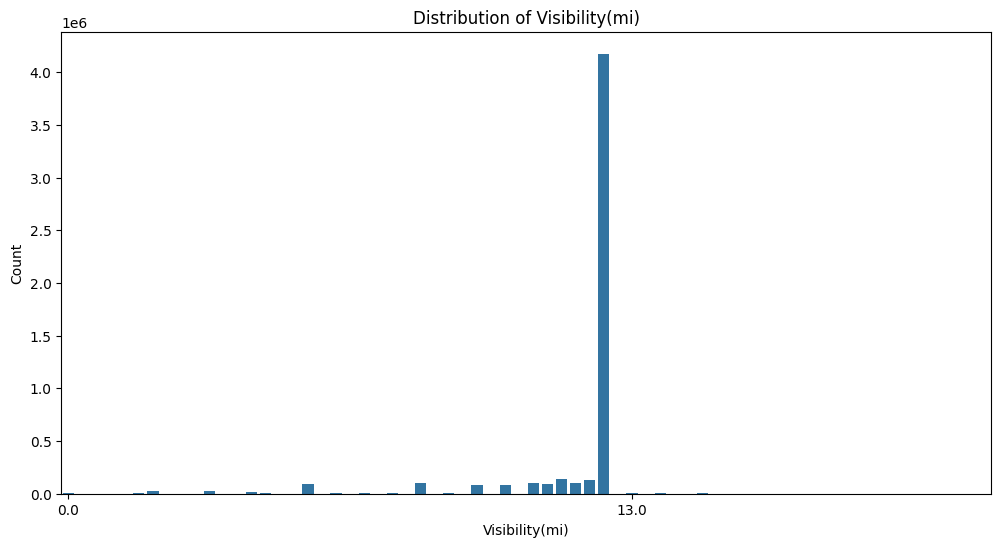

In [ ]:
cols_to_discretize = [
    #'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 
    'Visibility(mi)' #'Wind_Speed(mph)', 'Precipitation(in)'
]

for col in cols_to_discretize:
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(x=data[col])
    ticks = ax.get_xticks()
    ax.set_xticks(ticks[::40])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


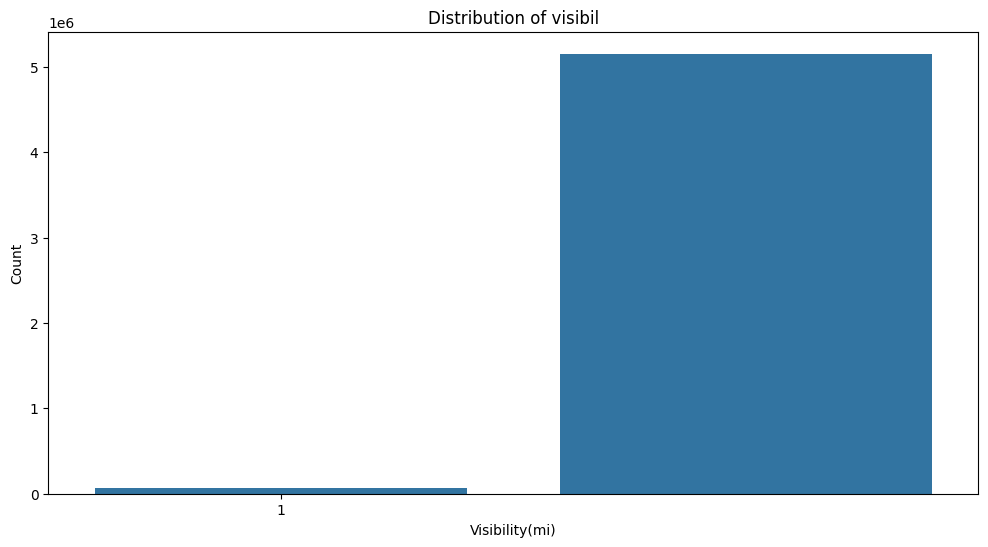

In [ ]:
# Equal-Width Binning (era meglio Quantile-Based Discretization ???)
discrete_bins = 5

cols_to_discretize = [
    'Wind_Chill(F)', 'Humidity(%)', 'Wind_Speed(mph)', 'Precipitation(in)'
]

for col in cols_to_discretize:
    min_val = data[col].min()
    max_val = data[col].max()
    # Creazione dei bin con ampiezza fissa
    bins = pd.cut(data[col], bins=np.linspace(min_val, max_val, discrete_bins+1), include_lowest=True)
    print(f"{col} -> {bins.dtype.categories}")
    bin2int = {x: i for i, x in enumerate(bins.dtype.categories)}
    data[col] = bins.apply(lambda x: bin2int[x]).astype(np.uint8)


#Discretize Temperature
bins = [-float('inf'), 45, 80, float('inf')]  # Intervalli
labels = [1, 2, 3]  # Etichette corrispondenti
data['Temperature(F)'] = pd.cut(data['Temperature(F)'], bins=bins, labels=labels)

#Discretize Visibility
bins = [-float('inf'), 0.55, float('inf')]  # non ho capito un cazzo dell'unità di misura 
labels = [1, 2]
data['Visibility(mi)'] = pd.cut(data['Visibility(mi)'], bins=bins, labels=labels)

# Mostriamo il risultato
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=data['Visibility(mi)'])
ticks = ax.get_xticks()
ax.set_xticks(ticks[::50])
plt.title(f'Distribution of visibil')
plt.xlabel('Visibility(mi)')
plt.ylabel('Count')
plt.show()



In [17]:
data.describe(include='all')

,Severity,State,Temperature(F),Wind_Chill(F),Humidity(%),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Crossing,Junction,Stop,Traffic_Signal,Sunrise_Sunset,temp_discretizzata
count,5.221072e+06,5221072,5221072.0,5.221072e+06,5.221072e+06,5.221072e+06,5.221072e+06,5.221072e+06,5221072,5221072,5221072,5221072,5221072,5221072,5221072.0
unique,NaN,49,3.0,NaN,NaN,NaN,NaN,NaN,127,2,2,2,2,2,3.0
top,NaN,CA,2.0,NaN,NaN,NaN,NaN,NaN,Fair,False,False,False,False,Day,2.0
freq,NaN,1122958,3254457.0,NaN,NaN,NaN,NaN,NaN,2424538,4658355,4864169,5076974,4549773,3531466,3254457.0
mean,2.147981e+00,NaN,NaN,1.828025e+00,2.703143e+00,9.783431e-04,3.639099e-06,2.030234e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.447808e-01,NaN,NaN,4.397776e-01,1.146259e+00,4.324261e-02,3.063500e-03,5.324121e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.000000e+00,NaN,NaN,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000e+00,NaN,NaN,2.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.000000e+00,NaN,NaN,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5217953 entries, 5 to 7728393
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Severity           int64 
 1   State              object
 2   Temperature(F)     uint8 
 3   Wind_Chill(F)      uint8 
 4   Humidity(%)        uint8 
 5   Pressure(in)       uint8 
 6   Visibility(mi)     uint8 
 7   Wind_Speed(mph)    uint8 
 8   Precipitation(in)  uint8 
 9   Weather_Condition  object
 10  Crossing           bool  
 11  Junction           bool  
 12  Stop               bool  
 13  Traffic_Signal     bool  
 14  Sunrise_Sunset     object
dtypes: bool(4), int64(1), object(3), uint8(7)
memory usage: 253.8+ MB


In [ ]:
data.head()

,Severity,State,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Crossing,Junction,Stop,Traffic_Signal,Sunrise_Sunset
5,3,OH,1,1,4,2,0,0,0,Light Rain,False,False,False,False,Day
9,3,OH,1,1,4,2,0,0,0,Light Rain,False,False,False,False,Day
11,3,OH,1,1,4,2,0,0,0,Light Rain,False,False,False,False,Day
14,2,OH,1,1,4,2,0,0,0,Light Rain,False,False,False,True,Day
20,2,OH,1,1,4,2,0,0,0,Light Snow,False,False,False,False,Day


### Custom model

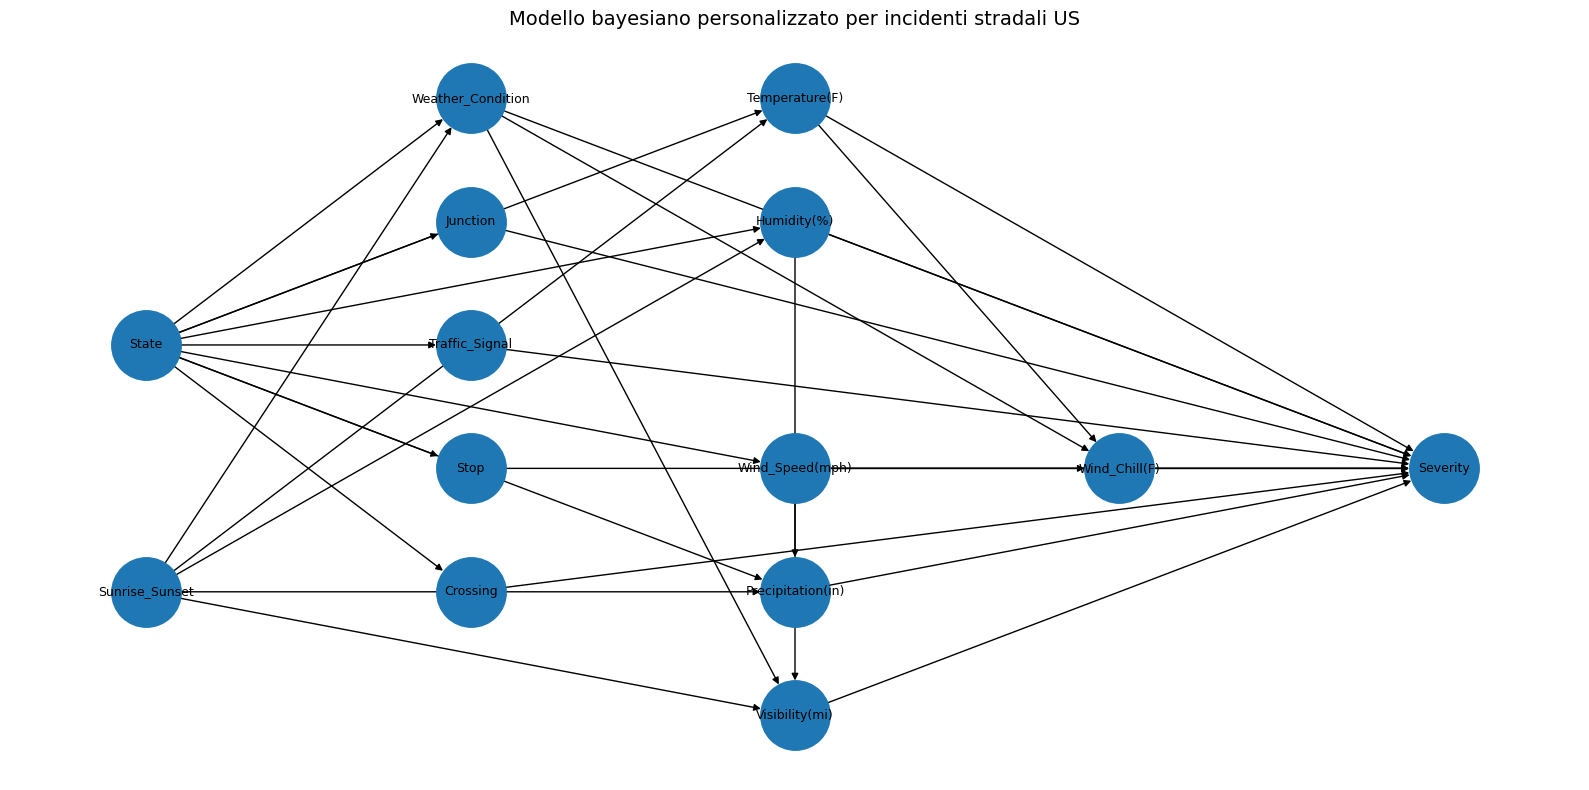

In [18]:
# Definizione del modello bayesiano con relazioni personalizzate
custom_model = BayesianModel([
    # Relazioni legate allo stato e all'ambiente
    ('State', 'Weather_Condition'),
    ('State', 'Junction'),
    ('State', 'Traffic_Signal'),
    ('State', 'Stop'),
    ('State', 'Crossing'),
    ('State', 'Temperature(F)'),
    ('State', 'Humidity(%)'),
    # ('State', 'Pressure(in)'),
    ('State', 'Wind_Speed(mph)'),
    ('State', 'Precipitation(in)'),

    # ('Weather_Condition', 'Temperature(F)'),
    # ('Weather_Condition', 'Humidity(%)'),
    # ('Weather_Condition', 'Pressure(in)'),
    # ('Weather_Condition', 'Wind_Speed(mph)'),
    # ('Weather_Condition', 'Precipitation(in)'),
    ('Weather_Condition', 'Visibility(mi)'),
    
    # Calcolo del Wind_Chill a partire da Temperature e Wind_Speed
    ('Temperature(F)', 'Wind_Chill(F)'),
    ('Wind_Speed(mph)', 'Wind_Chill(F)'),
    ('Wind_Speed(mph)', 'Visibility(mi)'),
    
    # Influenza di Sunrise_Sunset sulla visibilità
    ('Sunrise_Sunset', 'Visibility(mi)'),
    ('Sunrise_Sunset', 'Temperature(F)'),
    ('Sunrise_Sunset', 'Humidity(%)'),
    # ('Sunrise_Sunset', 'Pressure(in)'),
    ('Sunrise_Sunset', 'Weather_Condition'),
    ('Sunrise_Sunset', 'Precipitation(in)'),

    ('Weather_Condition', 'Wind_Chill(F)'),
    ('Weather_Condition', 'Severity'),
    

    ('Humidity(%)', 'Precipitation(in)'),
    # ('Pressure(in)', 'Weather_Condition'),
    
    
    # Fattori infrastrutturali e ambientali che influenzano la gravità dell'incidente
    ('Junction', 'Severity'),
    ('Traffic_Signal', 'Severity'),
    ('Stop', 'Severity'),
    ('Crossing', 'Severity'),
    ('Precipitation(in)', 'Severity'),
    ('Visibility(mi)', 'Severity'),
    ('Wind_Chill(F)', 'Severity'),
    ('Temperature(F)', 'Severity'),
    ('Humidity(%)', 'Severity'),
    # ('Pressure(in)', 'Severity'),
    ('Wind_Speed(mph)', 'Severity'),
])

# Posizioni dei nodi su una griglia a colonne
pos = {
    # Column 1: Basic factors
    'State':           (0, 0),
    'Sunrise_Sunset':  (0, -2),

    # Column 2: Environmental signals and junction-related factors
    'Weather_Condition': (2, 2),
    'Junction':          (2, 1),
    'Traffic_Signal':    (2, 0),
    'Stop':              (2, -1),
    'Crossing':          (2, -2),

    # Column 3: Weather measurements
    'Temperature(F)':    (4, 2),
    'Humidity(%)':       (4, 1),
    # 'Pressure(in)':      (4, 0),
    'Wind_Speed(mph)':   (4, -1),
    'Precipitation(in)': (4, -2),
    'Visibility(mi)':    (4, -3),

    # Column 4: Derived weather measurement
    'Wind_Chill(F)':     (6, -1),
    
    # Column 5: Outcome
    'Severity':          (8, -1)
}

# Creazione della figura e disegno del grafo
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
nx.draw_networkx(
    custom_model,
    pos=pos,
    ax=ax,
    node_size=2500,
    font_size=9,
    arrows=True
)
ax.set_title('Modello bayesiano personalizzato per incidenti stradali US', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [19]:
import io
import sys

# Reset learned CPDs and refit the model
custom_model.cpds = []
custom_model.fit(data)

from pgmpy.factors.discrete.CPD import TabularCPD

def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

# Capture printed output using StringIO
old_stdout = sys.stdout
sys.stdout = mystdout = io.StringIO()

# Print all the learned CPTs
for cpd in custom_model.get_cpds():
    print('CPT of {}'.format(cpd.variable))
    print_full(cpd)
    print('\n')

# Restore original stdout
sys.stdout = old_stdout

# Save captured output to a file
with open('CPDs.txt', 'w', encoding='utf-8') as file:
    file.write(mystdout.getvalue())

KeyboardInterrupt: 

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

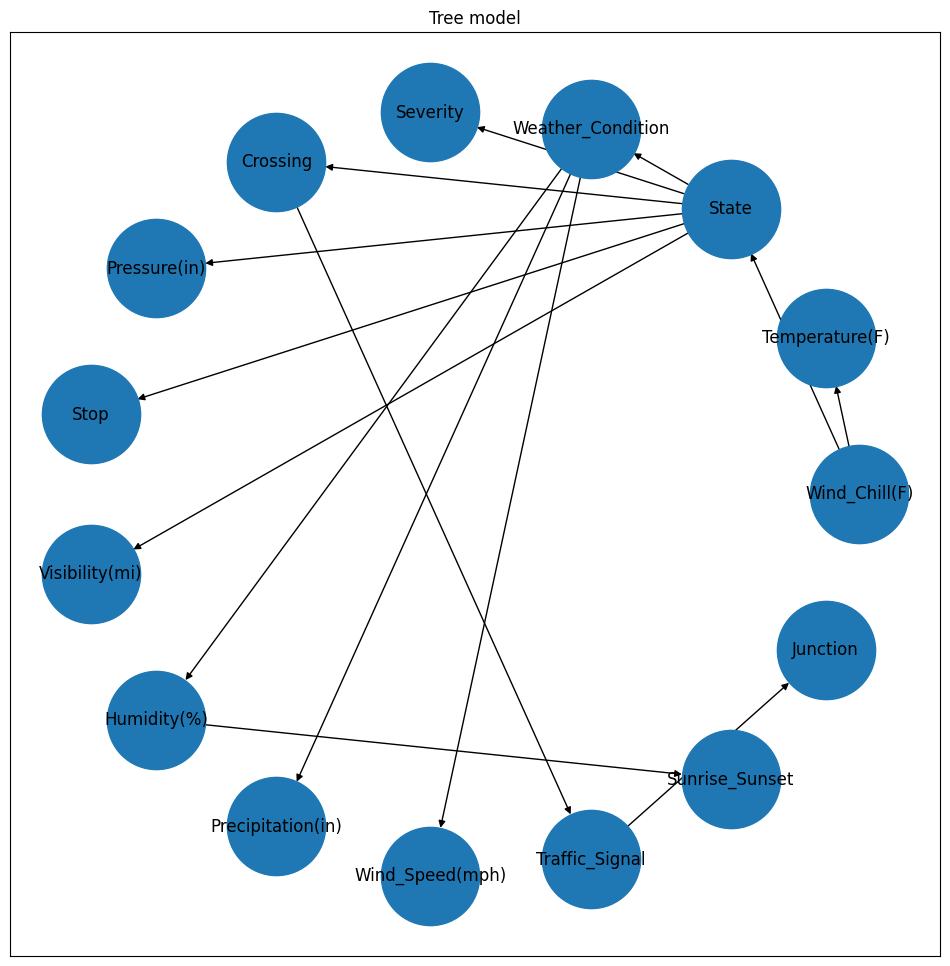

In [ ]:
# ts = TreeSearch(data=data, root_node='State')
ts = TreeSearch(data=data)
tree_model = ts.estimate()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=5000)
# fig.savefig('tree')
ax.set_title('Tree model')
tree_model = BayesianModel(tree_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

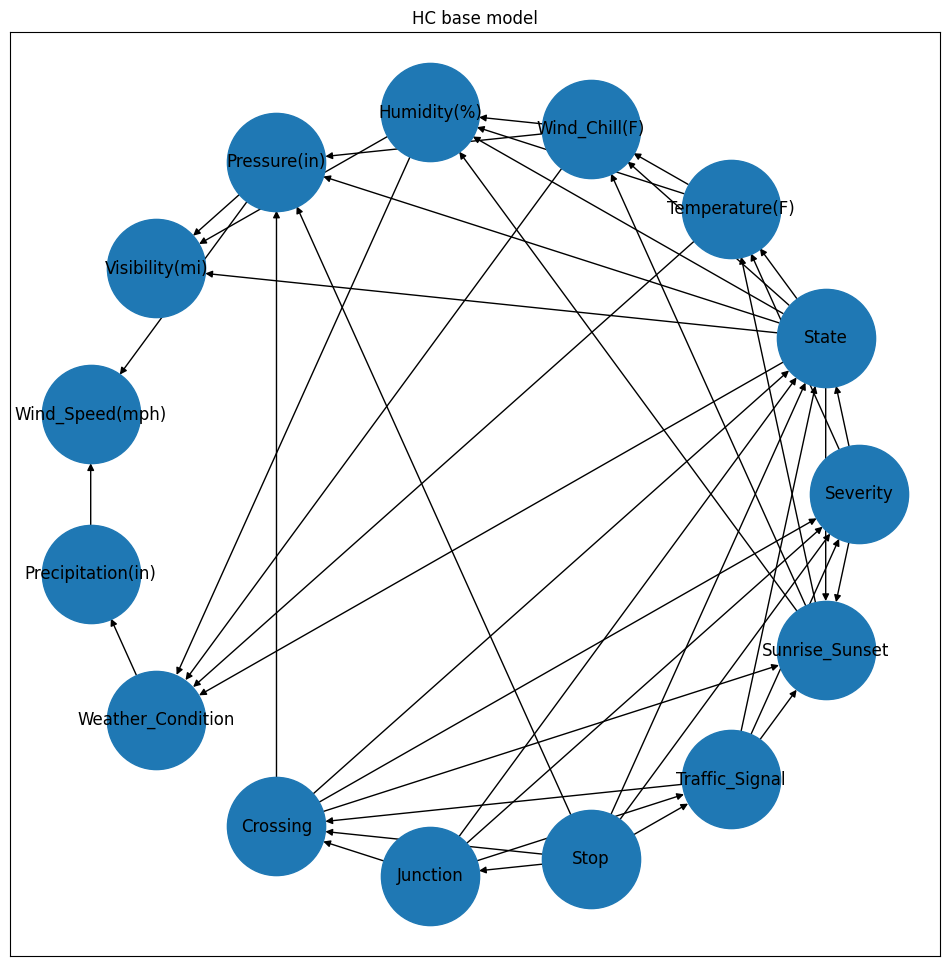

In [ ]:
# scorer = BDeuScore(data=data)
# hc = HillClimbSearch(data=data)
# hc_base_model = hc.estimate(scoring_method=scorer)

# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# nx.draw_networkx(hc_base_model, pos=nx.drawing.layout.circular_layout(hc_base_model), ax=ax, node_size=5000)
# # fig.savefig('hc_base')
# ax.set_title('HC base model')
# hc_base_model = BayesianModel(hc_base_model.edges())